<a href="https://colab.research.google.com/github/AlessandroSerra/ML_Projects/blob/main/HIGGS_GBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#dataset dell'Higgs

!wget https://bortigno.web.cern.ch/bortigno/machine-learninig/datasets/vhcc_tree.root

#dataset di fondo

!wget https://bortigno.web.cern.ch/bortigno/machine-learninig/datasets/dyll-nlo_tree.root

--2022-08-05 07:20:31--  https://bortigno.web.cern.ch/bortigno/machine-learninig/datasets/vhcc_tree.root
Resolving bortigno.web.cern.ch (bortigno.web.cern.ch)... 188.185.90.17, 2001:1458:d00:41::100:268
Connecting to bortigno.web.cern.ch (bortigno.web.cern.ch)|188.185.90.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87008247 (83M)
Saving to: ‘vhcc_tree.root’

vhcc_tree.root      100%[===================>]  82.98M  19.9MB/s    in 4.2s    

2022-08-05 07:20:36 (19.9 MB/s) - ‘vhcc_tree.root’ saved [87008247/87008247]

--2022-08-05 07:20:36--  https://bortigno.web.cern.ch/bortigno/machine-learninig/datasets/dyll-nlo_tree.root
Resolving bortigno.web.cern.ch (bortigno.web.cern.ch)... 188.185.90.17, 2001:1458:d00:41::100:268
Connecting to bortigno.web.cern.ch (bortigno.web.cern.ch)|188.185.90.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269204427 (257M)
Saving to: ‘dyll-nlo_tree.root’

dyll-nlo_tree.root  100%[===================>

In [ ]:
!pip install uproot
!pip install lz4 xxhash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 302 kB 3.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.0 MB/s 
     |████████████████████████████████| 212 kB 51.5 MB/s 


In [ ]:
import uproot
import pandas

In [ ]:
df = {}

In [ ]:
branches = ['ak15_pt', 'ak15_eta', 'ak15_phi', 'ak15_deltaR_sj12', 'ak15_sj1_pt', 'ak15_sj2_pt']

In [ ]:
df['sig'] = uproot.open('vhcc_tree.root')['Events'].arrays(branches, library='pd')
df['bkg'] = uproot.open('dyll-nlo_tree.root')['Events'].arrays(branches, library='pd')

In [ ]:
import numpy as np

#impostiamo degli array che associno ad un evento 1 ed al background 0
uno = np.ones(len(df['sig']))
zero = np.zeros(len(df['bkg']))

#uniamo segnale e background per formare l'array X e i risultati per l'array Y
X = np.concatenate((df['sig'], df['bkg']))
y = np.concatenate((uno, zero))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
X_train.shape

(790317, 6)

In [ ]:
percs = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
scores = []
gbcs = []

for perc in percs:
    X_train_temp = X_train[0:int(perc*len(X_train))]
    y_train_temp = y_train[0:int(perc*len(y_train))]
    gbc = GradientBoostingClassifier(learning_rate=0.5, n_estimators=100)
    gbc.fit(X_train_temp, y_train_temp)
    gbcs.append(gbc)
    scores.append(gbc.score(X_test, y_test))

In [ ]:
import matplotlib.pyplot as plt

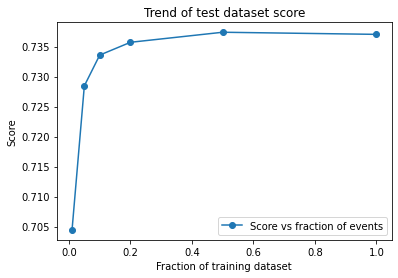

In [ ]:
fig, ax = plt.subplots()

ax.plot(percs, scores, label='Score vs fraction of events', marker='o')
ax.set_xlabel('Fraction of training dataset')
ax.set_ylabel('Score')
ax.set_title('Trend of test dataset score')

plt.legend()
plt.show()

In [ ]:
scores[3]

0.7357159125417553

In [ ]:
X_train_def = X_train[0:int(0.2*len(X_train))]
y_train_def = y_train[0:int(0.2*len(y_train))]

In [ ]:
estimators = [1, 10, 50, 100, 200, 250, 500]
scores2 = []
gbcs2 = []

for estimator in estimators:
    gbc = GradientBoostingClassifier(learning_rate=0.5, n_estimators=estimator)
    gbc.fit(X_train_def, y_train_def)
    gbcs.append(gbc)
    scores2.append(gbc.score(X_test, y_test))

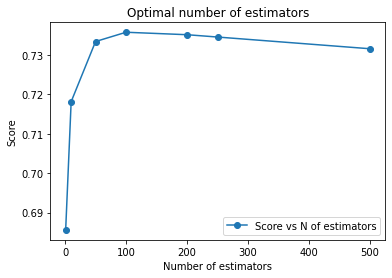

In [ ]:
fig, ax = plt.subplots()

ax.plot(estimators, scores2, label='Score vs N of estimators', marker='o')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Score')
ax.set_title('Optimal number of estimators')

plt.legend()
plt.show()

In [ ]:
rates = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 1.5]
scores3 = []
gbcs3 = []

for rate in rates:
    gbc = GradientBoostingClassifier(learning_rate=rate, n_estimators=100)
    gbc.fit(X_train_def, y_train_def)
    gbcs3.append(gbc)
    scores3.append(gbc.score(X_test, y_test))

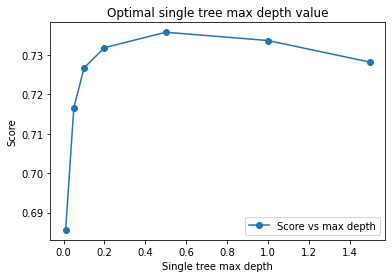

In [ ]:
fig, ax = plt.subplots()

ax.plot(rates, scores3, label='Score vs max depth', marker='o')
ax.set_xlabel('Single tree max depth')
ax.set_ylabel('Score')
ax.set_title('Optimal single tree max depth value')

plt.legend()
plt.show()

In [ ]:
depths = [1, 2, 5, 10, 15]
scores6 = []

for depth in depths:
    gbc = GradientBoostingClassifier(learning_rate=0.5, n_estimators=100, min_samples_split=20, min_samples_leaf=10, max_depth=depth)
    gbc.fit(X_train_def, y_train_def)
    gbcs3.append(gbc)
    scores6.append(gbc.score(X_test, y_test))

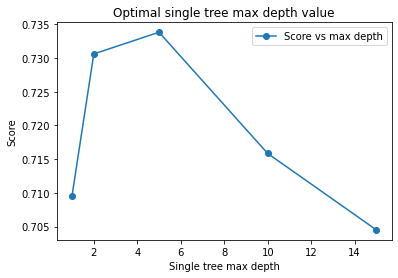

In [ ]:
fig, ax = plt.subplots()

ax.plot(depths, scores6, label='Score vs max depth', marker='o')
ax.set_xlabel('Single tree max depth')
ax.set_ylabel('Score')
ax.set_title('Optimal single tree max depth value')

plt.legend()
plt.show()

In [ ]:
gbc_def = GradientBoostingClassifier(learning_rate=0.5, n_estimators=100, max_depth=5)
gbc_def.fit(X_train_def, y_train_def)

GradientBoostingClassifier(learning_rate=0.5, max_depth=5)

In [ ]:
gbc_def.score(X_test, y_test)

0.7338407227452172

In [ ]:
gbc_fpr, gbc_tpr, gbc_threshold = roc_curve(y_test, gbc_def.predict(X_test), drop_intermediate=False) 
print(gbc_threshold)
print(gbc_tpr)
print(gbc_fpr)

[2. 1. 0.]
[0.         0.40632924 1.        ]
[0.         0.11597958 1.        ]


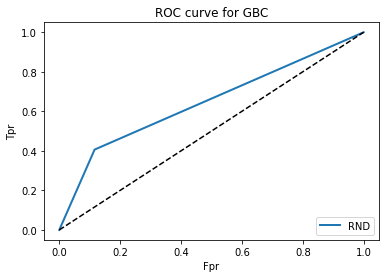

In [ ]:
def plot_roc_curve(fpr, tpr,threshold=None ,label=None):
    '''
    funzione che plotta la roc curve a partire da fpr e tpr
    '''
    plt.plot(fpr, tpr, linewidth=2, label= label)
    plt.plot([0,1], [0,1], 'k--') #riga tratteggiata diagonale
    plt.xlabel('Fpr')
    plt.ylabel('Tpr')
    plt.legend(loc='lower right')
    plt.title('ROC curve for GBC')
#uso la funzione appena creata
plot_roc_curve(gbc_fpr, gbc_tpr, gbc_threshold,'RND') 
#plotto
plt.show()

In [ ]:
roc_auc_score(y_test, gbc_def.predict(X_test))

0.6451748274888389

In [ ]:
df_full = {}

In [ ]:
branches_full = ['ak15_pt', 'ak15_sdmass', 'ak15_eta', 'ak15_phi', 'ak15_ParticleNetMD_Xcc', 'ak15_deltaR_sj12', 'ak15_sj1_pt', 'ak15_sj2_pt']

In [ ]:
df_full['sig'] = uproot.open('vhcc_tree.root')['Events'].arrays(branches_full, library='pd')
df_full['bkg'] = uproot.open('dyll-nlo_tree.root')['Events'].arrays(branches_full, library='pd')

In [ ]:
import numpy as np

#impostiamo degli array che associno ad un evento 1 ed al background 0
uno_full = np.ones(len(df_full['sig']))
zero_full = np.zeros(len(df_full['bkg']))

#uniamo segnale e background per formare l'array X e i risultati per l'array Y
X_full = np.concatenate((df_full['sig'], df_full['bkg']))
y_full = np.concatenate((uno_full, zero_full))

In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, random_state=0)

In [ ]:
X_train_full_def = X_train_full[0:int(0.2 * len(X_train_full))]
y_train_full_def = y_train_full[0:int(0.2 * len(y_train_full))]

In [ ]:
gbc_full_def = GradientBoostingClassifier(learning_rate=0.5, n_estimators=100, max_depth=2)
gbc_full_def.fit(X_train_full_def, y_train_full_def)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2)

In [ ]:
gbc_full_def.score(X_test_full, y_test_full)

0.7588065593683572

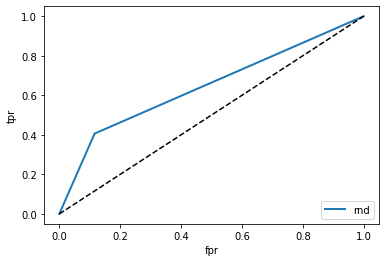

In [ ]:
gbc_fpr2, gbc_tpr2, gbc_threshold2 = roc_curve(y_test_full, gbc_full_def.predict(X_test_full), drop_intermediate=False) 
#uso la funzione appena creata
plot_roc_curve(gbc_fpr, gbc_tpr, gbc_threshold,'rnd') 
#plotto
plt.show()

In [ ]:
roc_auc_score(y_test_full, gbc_full_def.predict(X_test_full))

0.672249934266894